# Mehrdimensionale Gaußverteilungen
29.7.2019, S. Mack

In [1]:
# display plots inside this notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

## Einleitung
Der Kalman-Filter aus dem voran gegangenen Kapitel zeigt eine sehr gute Wirkung bei verrauschten Messdaten, wenn das zugrunde liegende physikalische Modell (der "Prozess") und die entsprechenden Varianzen gut gewählt sind. In einer Hinsicht ist er aber noch nicht auf Augenhöhe mit dem g-h-Filter:  
Beim g-h-Filter konnte über dessen Skalierungsfaktor $h$ einstellt werden, wie sich der Parameter der Zuständsänderung im physikalischen Modell an die vorliegende Messwertänderung anpasst. Beim g-h-Filter wird beispielsweise durch das physikalische Modell lediglich vorgegeben, das Roboterfahrzeug bewege sich geradlinig. Für die Vorhersage ist aber wichtig, in welchem Winkel es sich zur Wand bewegt. Dieser Winkel als Parameter des physikalischen Modells wird beim g-h-Filter über Skalierungsfaktor $h$ "der Realität" angepasst.  

Beim eindimensionalen Kalman-Filter des vorherigen Jupyter-Notebooks gab das physikalische Modell nicht nur die geradlinige Bewegung des Roboterfahrzeugs sondern auch den Winkel vor. War der Parameter für den Winkel falsch, so so wurde dieser nicht wie beim g-h-Filter im Verlauf der Filteriterationen an den tatsächlichen Wert angepasst.  

**Der Kalman-Filter soll nun so erweitert werden, dass er nicht nur den Abstand sondern auch den Winkel zur Wand (also die Abstandsänderung) "trackt".** Die Begriffe "Winkel" und "Abstandsänderung" (pro Zeit) sind beim Roboterfahrzeug gewissermaßen gleichbedeutend und werden fortan synonym verwendet.  
**Dies könnte man mit zwei völlig getrennten Kalman-Filtern, einer für den Abstand und einer für die Abstandsänderung, machen. Der Abstand und die Abstandsänderung sind aber statistisch miteinander gekoppelt. Sie bilden eine zweidimensionale Gaußverteilung. D.h. es muss ein gemeinsamer Kalmanfilter für diese beiden Zustandsgrößen her, der derern gegenseitige Beziehung berücksichtigt!  
Die Grundlage hierfür sind mehrdimensionale Gaußverteilungen.**

## Gaußverteilung: Von eindimensional zu zweidimensional
Im Jupyter-Notebook zu den Grundlagen der Wahrscheinlichkeitsrechnung wurde die (eindimensionale) Gaußverteilung (=Normalverteilung) eingeführt:
$$ f(x, \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\big [{-\frac{(x-\mu)^2}{2\sigma^2} }\big ]$$
Dass eine Zufallsvariable $X$ einer Normalverteilung mit Erwartungswert $\mu$ und Standardabweichung $\sigma$ folgt, wird mathematisch allgemein in der Form $X \sim \mathcal N (\mu,\sigma^2)$ ausgedrückt.  

Es wurde als Beispiel eine Gruppe von Studierenden als Stichprobe behandelt, wobei die Zufallsvariable deren Körpergröße war. Dieses Beispiel soll hier wieder aufgegriffen werden - nur jetzt mit mehr Studierenden innerhalb der Stichprobe.  

### Beispiel Stichprobe von Studierenden: Zufallsvariable Körpergröße und Gewicht
Nachfolgend sind die Körpergrößen von 12 Studierenden wiedergegeben und deren Verteilung als Gaußkurve dargestellt.

Mittelwert Größe: 1.85
Varianz Größe: 0.021


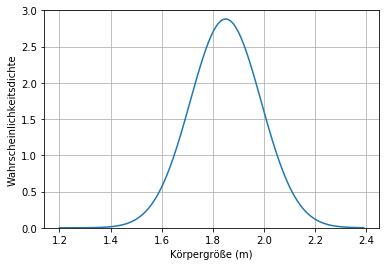

In [2]:
from scipy.stats import norm
# sample of body height of 12 students
x_height = [1.8, 2.0, 1.7, 1.9, 1.6, 1.8, 1.7, 1.9, 2.1, 2.0, 1.8, 1.9]

x = np.arange(1.2,2.4,0.01)
mu = np.mean(x_height)
sigma = np.sqrt(np.var(x_height))
pdf_gauss = norm.pdf(x,mu,sigma)

fig, ax = plt.subplots()
ax.plot(x,pdf_gauss)
ax.set_xlabel('Körpergröße (m)')
ax.set_ylabel('Wahrscheinlichkeitsdichte')
ax.set_ylim(0,3)
ax.grid()
print('Mittelwert Größe: {}'.format(mu.round(3)))
#ddof=1 to get variance of entire population to get same result as for np.cov()
print('Varianz Größe: {}'.format(np.var(x_height,ddof=1).round(3))) 

Eine weitere Zufallsvariable dieser Stichprobe von Studierenden ist deren Gewicht. Das Array ``x_weight`` gibt das Gewicht des jeweiligen Studierenden wieder. Der Student mit Körpergröße 1,80 m auf Platz 0 des Arrays hat beispielsweise ein Gewicht von 75 kg.

In [3]:
# sample of body weight of 12 students
x_weight = [75, 85, 72, 82, 69, 74, 70, 81, 84, 82, 77, 83]
print('Mittelwert Gewicht: {}'.format(np.mean(x_weight).round(3)))
print('Varianz Gewicht: {}'.format(np.var(x_weight,ddof=1).round(3)))

Mittelwert Gewicht: 77.833
Varianz Gewicht: 32.515


Die Verteilung der Körpergrößen und der Gewichte stellt eine *zweidimensionale Gaußverteilung* dar. Diese besitzt anders als die eindimensionale Gaußverteilung einen Erwartungswert und eine Varianz in *Form eines Arrays mit jeweils zwei Elementen* - Element 0 für die Körpergrößen und Element 1 für das Gewicht. Allgemein für N Zufallsvariablen ergibt sich ein Array mit N-1 Elementen:
$$
\mu = \begin{bmatrix}\mu_0\\\mu_1\\ \vdots \\\mu_{N-1}\end{bmatrix}
$$

Bei der hier betrachteten Stichprobe von Studierenden ergibt sich

$$
\mu = \begin{bmatrix}1,85\\77,8\end{bmatrix} 
$$

Entsprechend ließe sich die Varianz als Array darstellen. Nur ist hierbei ein entscheidender Aspekt nicht berücksichtigt:  
Genau so wie die Zustandsgrößen Abstand und Abstandsänderung beim Roboterfahrzeug sind die hier betrachteten Zufallsvariablen Körpergröße und Gewicht nicht komplett unabängig von einander.  
Man sagt *sie sind korreliert*. Je größer ein Mensch ist, desto schwerer ist er im Allgemeinen auch. Dies heißt aber nicht, dass man aufgrund der Körpergröße eines Studierenden exakt dessen Gewicht vorhersagen kann. *Aber man kann dessen **wahscheinlichstes** Gewicht vorhersagen.*   

Die Varianz einer zweidimensionalen Gaußverteilung ist also nicht als Array darstellbar - man benötigt eine 2x2-Matrix (-Array), in der zusätzlich zu den Varianzen der beiden Zufallsvariablen auch noch deren Korellation enthalten ist.  
Um diese Korellation zu verdeutlichen, sind im folgendem Plot die beiden Zufallsvariablen gegeneinander eingetragen und eine Ausgleichsgerade eingezeichnet. Die Gerade steht hier für die *lineare* Korrelation.

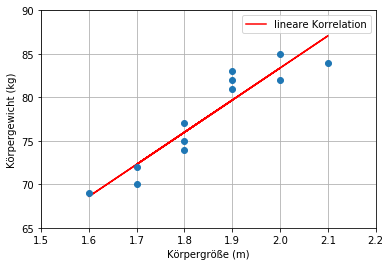

In [4]:
line = np.poly1d(np.polyfit(x_height, x_weight, 1))
plt.figure()
plt.plot (x_height, line(x_height), c='r', label='lineare Korrelation')
plt.plot (x_height, x_weight, 'o')
plt.xlim(1.5, 2.2)
plt.ylim(65, 90)
plt.xlabel('Körpergröße (m)')
plt.ylabel('Körpergewicht (kg)')
plt.legend()
plt.grid()

## Korrelation und Kovarianz
### Die Kovarianzmatrix
Die Kovarianz ist ein Maß für die Assoziation zweier Zufallsvariablen. Damit ist gemeint, dass hohe Werte einer Zufallsvariablen tendenziell mit hohen (oder auch niedrigen) Werten einer anderen Zufallsvariablen einhergehen. Dazu sagt man auch, beide Größen *korrelieren*, wobei hier explizit eine *lineare* Korrelation gemeint ist. Dies macht sich im Plot oben dadurch bemerkbar, dass zu den Datenpunkten aus Körpergrößen vs. Gewicht eine Ausgleichs*gerade* stimmig passt.  

Es gibt auch eine nichtlineare Korrelation: Zum Beispiel ist die Unfallhäufigkeit mit dem Alter des Autofahrers korreliert. Jedoch hat hier die Verteilung in etwa eine U-Form: Sowohl besonders junge als auch besonders alte Fahrer verursachen gehäuft Unfälle.  
Ein Maß dafür wie eine einzelne Zufallsvariable streut ist deren Varianz. Die Kovarianz quantifiziert wie die beiden Varianzen zweier Zufallsvariablen "korreliert" streuen. Sozusagen "korrelierte Varianz" - daher der Begriff "Kovarianz".  

Für den Kalman-Filter ist die Kovarianz wichtig, denn durch sie lässt sich eine Vorhersage präzisieren: Wenn ein Studierender 2,10 m groß ist, dann kann in unserem Beispiel dessen Gewicht zu ca. 87 kg vorhergesagt werden.  

Die Kovarianz ist mathematisch definiert als:
$$ COV(X_0, X_1) = \sigma_{01} = E\big[(X_0-\mu_x)(X_1-\mu_y)\big]$$

Hier ist $ E[X]$ der *Erwartungswert* definiert als

$$ E[X] =  \begin{cases} \sum_{i=1}^n p_ix_i & \mbox{diskrete Zufallsverteilung}\\ \int_{-\infty}^\infty f(x)\, x & \mbox{kontinuierliche Zufallsverteilung}\end{cases}$$

Die Kovarianz ist mathematisch also der Erwartungswert aus dem Produkt der Abweichung der einen Zufallsvariable von deren Erwartungswert mal der Abweichung der anderen Zufallsvariable von deren Erwartungswert.  

Die Definitionsgleichungen für die Varianz und für die Kovarianz sind recht ähnlich:

$$\begin{aligned}VAR(X_0) &= \sigma_0^2 = E[(X_0 - \mu_0)^2] \\
COV(X_0, X_1) &= \sigma_{01} = E\big[(X_0-\mu_0)(X_1-\mu_1)\big]
\end{aligned}$$

Berechnet man die Varianz $COV(X_0, X_0)$ aus einer Zufallsvariable mit sich selbst, so ergibt sich die Varianz $VAR(X_0)$ dieser Zufallsvariablen.

Die Varianz einer mehrdimensionalen Gaußverteilung lässt sich also nicht als Array darstellen, da nicht nur die Varianzen sondern auch noch die Kovarianzen diese Verteilung charakterisieren. Daher wird eine solche mehrdimensionale Varianz als **Kovarianzmatrix** dargestellt. Für eine zweidimensionale Zufallsverteilung hat diese Matrix folgende Form:  

$$
\mathbf \Sigma = \begin{bmatrix}
  \sigma_0^2 & \sigma_{01} \\
  \sigma_{10} &\sigma_1^2  \\
 \end{bmatrix}
$$

Bei Bespiel der Stichprobe der Studierenden bezeichnet $\sigma_0^2$ die Varianz der Größen, $\sigma_1^2$ die Varianz der Gewichte, $\sigma_{01}$ bzw. $\sigma_{10}$ die Kovarianz zwischen Größe und Gewicht.

Für eine n-dimensionale Zufallsverteilung ergibt sich folglich eine n x n-Matrix:

$$
\mathbf\Sigma = \begin{bmatrix}
  \sigma_0^2 & \sigma_{01} & \cdots & \sigma_{0(n-1)} \\
  \sigma_{10} &\sigma_1^2 & \cdots & \sigma_{1(n-1)} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  \sigma_{(n-1)0} & \sigma_{(n-1)1} & \cdots & \sigma_{n-1}^2
 \end{bmatrix}
$$

Die Kovarianzmatrix ist immer symmetrisch. Somit gilt $\sigma_{nm}=\sigma_{mn}$ für jedes $n$ und $m$. Die Diagonale besteht aus den Varianzen der entsprechenden Zufallsvariablen. Sind die Elemente außerhalb dieser Diagonalen gleich Null, dann sind die Zufallsvariablen unkorreliert zueinander.  



### Die Kovarianzmatrix am Beispiel einer zweidimensionalen Gaußverteilung
$X_0$ und $X_1$ seien zwei Zufallsvariablen. Nachfolgend sind für unterschiedliche Korrelationsausmaße dieser beiden Verteilungen die entsprechenden Kovarianzmatrizen dargestellt. Die Kovarianzmatrix $\mathbf\Sigma$ wird jeweils mit der Funktion ``np.cov()`` aus der NumPy-Bibliothek berechnet.
#### Komplett unkorrelierte Zufallsvariable
Sowohl $X_0$ als auch $X_1$ sind von einander unabhängige Zufallsverteilungen. Die Elemente außerhalb der Diagonalen von $\mathbf\Sigma$ sind nahezu Null. Theoretisch müssten Sie gleich Null sein, jedoch zeigt sich hier, dass numerisch generierte Zufallszahlen halt doch nicht 100 %ig zufällig sind, bzw. numerische Rundungsfehler im Spiel sind.  
In der Kovarianzmatrix ist (bis auf numerische Rundungsfehler) wie erwartet das Element $\Sigma_{00}$ gleich $1^2=1$ und das Element $\Sigma_{11}$ gleich $0.3^2=0.09$.

Kovarianzmatrix: [[1.008 0.   ]
 [0.    0.089]]


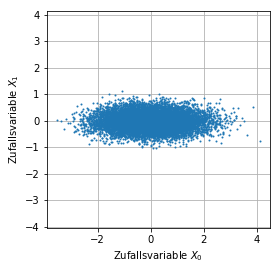

In [5]:
X_0 = np.random.randn(10000) # variance = 1
X_1 = 0.3 * np.random.randn(10000) # variance = 0.09
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(X_0, X_1, 'o', markersize=1)
ax.set_xlabel('Zufallsvariable $X_0$')
ax.set_ylabel('Zufallsvariable $X_1$')
ax.grid()
ax.axis('equal')

print('Kovarianzmatrix: {}'.format(np.cov(X_0, X_1).round(3))) # rounded to 3 digits after the period

#### Komplett korrelierte Zufallsvariable
Der entgegengesetzte Fall sind zwei Stichproben $X$ und $Y$, welche durch gleiche Arrays repräsentiert werden. Hier sind alle Elemente von $\mathbf\Sigma$ gleich groß und bis auf numerische Näherungsfehler gleich der Varianz.

Kovarianzmatrix: [[4.048 4.048]
 [4.048 4.048]]


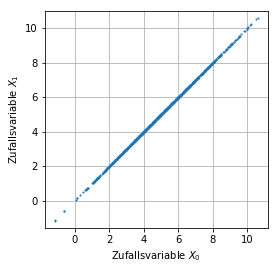

In [6]:
X_0 = 5 + 2*np.random.randn(1000) # variance = 4
X_1 = X_0 # variance = see above
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(X_0, X_1, 'o',  markersize=1)
ax.set_xlabel('Zufallsvariable $X_0$')
ax.set_ylabel('Zufallsvariable $X_1$')
ax.grid()
ax.axis('equal')

print('Kovarianzmatrix: {}'.format(np.cov(X_0, X_1).round(3)))

#### Teilkorrelierte Zufallsvariable
Im nächsten Beispiel wird die Stichprobe $Y$ aus dem vorherigen Beispiel etwas verrauscht. Dadurch geht die perfekte Korrelation veloren. Beide Zufallsvariablen bleiben aber immer noch stark korreliert. Dies sieht man an den vergleichsweise großen Elementen von $\mathbf\Sigma$ außerhalb der Diagonale.

Kovarianzmatrix: [[12.282  8.377]
 [ 8.377 12.361]]


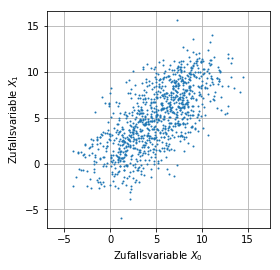

In [7]:
X_0 = np.linspace(0, 10, 1000) + 2*np.random.randn(1000)
X_1 = np.linspace(0, 10, 1000) + 2*np.random.randn(1000)
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(X_0, X_1, 'o',  markersize=1)
ax.set_xlabel('Zufallsvariable $X_0$')
ax.set_ylabel('Zufallsvariable $X_1$')
ax.grid()
ax.axis('equal')

print('Kovarianzmatrix: {}'.format(np.cov(X_0, X_1).round(3)))

In diese Rubrik zweier teilkorrelierten Zufallsvariablen fällt auch das Beispiel der Größen und des Gewichts von Studierenden:

Kovarianzmatrix: [[2.09090909e-02 7.72727273e-01]
 [7.72727273e-01 3.25151515e+01]]


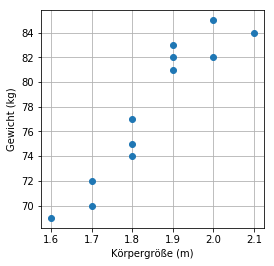

In [8]:
X_0 = x_height # variance height 0.021
X_1 = x_weight # variance weight 32.5
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(X_0, X_1, 'o')
ax.set_xlabel('Körpergröße (m)')
ax.set_ylabel('Gewicht (kg)')
ax.grid()
#with np.printoptions(precision=4, suppress=True): # conversion to decimals: works only with NumPy 1.15 or newer
print('Kovarianzmatrix: {}'.format(np.cov(X_0, X_1)))

Die Kovarianzmatrix dieser beiden Zufallsvariablen enthält mit $\sigma_0^2$ die Varianz der Körpergröße von 0,02 m², mit $\sigma_1^2$ die Varianz des Gewichts von 32,52 kg² sowie außerhalb der Diagonalen den Wert 0,77 kg m. Letzterer Wert ist ähnlich groß wie das Produkt $\sigma_0 \sigma_1$ beider Standardabweichungen 0,81 kg m, was auf eine starke Korrelation hinweist. Sein positives Vorzeichen deutet darauf hin, dass Körpergröße und Gewicht *positiv* korreliert sind, d.h. bei zunehmender Größe ist mit zunehmendem Gewicht zu rechnen.

## Die mehrdimensionale Gaußverteilung
Der Übergang von der eindimensionalen Gaußverteilung
$$ f(x, \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\big [{-\frac{(x-\mu)^2}{2\sigma^2} }\big ]$$
zur mehrdimensionalen Gaußverteilung ist eigentlich recht einfach: Aus den Skalaren $x$, $\mu$ und $\sigma$ werden die Vektoren $\mathbf{x}$, $\boldsymbol{\mu}$ bzw. die Matrix $\mathbf\Sigma$. D.h. prgrammiertechnisch wechselt man von einfachen Variablen zu Arrays. Im Gegensatz zu den Skalaren werden Vektoren bzw. Matrizen hier fettgedruckt dargestellt.

$$
f(\mathbf{x},\boldsymbol{\mu},\mathbf\Sigma) = \frac{1}{\sqrt{(2\pi)^n|\mathbf\Sigma|}}\, \exp  \Big [{ -\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu)}^\mathsf{T}\mathbf\Sigma^{-1}(\mathbf{x}-\boldsymbol{\mu}) \Big ]}
$$

Alle mehrdimensionalen Gaußverteilungen haben diese Form. Eine vernünftige grafische Darstellung der Verteilung ist leider nur bis zum zweidimensionalen Fall möglich. Denn die dritte Dimension wird ja für die Wahrscheinlichkeitsdichte benötigt.  

Die Funktion $f(x)$ wird wie im eindimensionalen Fall aus dem Jupyter-Notebook "Grundlagen der Wahrscheinlichkeitsrechnung" wieder als Dichtefunktion bezeichnet. Die Verteilungsfunktion $F(x)$ berechnet sich jetzt als Flächenintegral:
$$ P(z_0<x_0,z_1<x_1)=F(\mathbf{x}) = \int_{-\infty}^{x_0} \int_{-\infty}^{x_1}f(\mathbf{u},\boldsymbol{\mu},\mathbf\Sigma) \,du_0 du_1 $$  
Will man nun anhand der studentischen Größe-/Gewichtsverteilung wissen, wie hoch die Wahrscheinlichkeit ist, dass jemand größer 1,8 m und gleichzeitig schwerer als 75 kg ist, so berechnet sich dies zu $F(x_0 = 1,8\ m, x_1 = 75\ kg)$. Die Mathematik ändert sich nur insoweit, dass nun "zweidimensional" gerechnet wird: Statt Skalare werden nun Vektoren verwendet, und statt normaler Integrale werden Flächenintegrale berechnet.  

Möchte man nur die Wahrscheinlichkeitsdichtefunktion für die Größe wissen, egal wie schwer jemand ist, so muss die zweidimensionale Dichtefunktion über die Variable $x_1$ von $-\infty$ bis $+\infty$ integriert werden. Das Ergebnis ist dann wie zu erwarten eine eindimensionale Gaußverteilung als Dichtefunktion.

## Visualisierung zweidimensionaler Gaußverteilungen mittels derer Erwartungswerte und Kovarianzmatrizen

Die folgenden Plots visualisieren verschiedene über die Erwartungswerte und Kovarianzmatrizen vorgegebene zweidimensionale Gaußverteilungen. Dafür muss zuerst noch die Plotfunktion ``plot_3d_covariance`` erstellt werden:

In [9]:
from matplotlib import cm
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D # module is needed for plot_surface()

def plot_3d_covariance(mu, sigma, x_lim, y_lim):
    """ plots a 2x2 covariance matrix centered at mu in xy, probability in z.
    mu :  2x1 nd.array x and y coordinates of expected value
    cov : 2x2 nd.array with covariance matrix
    xy_lim: size of xy-plane
    A surface as well as a contour plot on the xy-surface will be displayed.
    """

    # Our 2-dimensional distribution will be over variables X and Y
    n = 60
    x = np.linspace(mu[0]-x_lim, mu[0]+x_lim, n)
    y = np.linspace(mu[1]-y_lim, mu[1]+y_lim, n)
    x, y = np.meshgrid(x, y)

    # Pack X and Y into a single 3-dimensional array of size (N,N,2)
    pos = np.empty((n,n,2))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    f = multivariate_normal(mu, sigma)
    z = f.pdf(pos)
    z_max = z.max().round(2) # needed later for z-offset of contour plot

    # Create a surface plot and projected filled contour plot under it.
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(x, y, z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)

    cset = ax.contourf(x, y, z, zdir='z', offset=-z_max, cmap=cm.viridis)

    # Adjust the limits, ticks and view angle
    ax.set_zlim(-z_max,z_max) # -z_max needed to display contour
    ax.set_zticks(np.linspace(0,z_max,5))
    ax.view_init(27, -21) 

Die Werte für $\boldsymbol{\mu}$ und $\Sigma$ sind jeweils aus den gleichnamigen Beispielen oben entnommen.  
Die Projektion der 3D-Flächen auf die xz- oder yz-Ebene ergeben wieder eine Gaußkurve. Denn diese entsprechen der Dichtefunktion für die jeweilige Zufallsvariable, egal welchen Wert die andere Zufallsvariable besitzt.  
Die Projektion auf die xy-Ebene, d.h. die Darstellung als 2D-Plot, bei dem die Wahrscheinlichkeitsdichte als Farbwert wiedergegeben wird, ergibt Muster in Form von Ellipsen. Diese sogenannten "Falschfarbenplots" sind vergleichbar mit topografischen Landkarten.

### 3D-Plots
#### 3D-Plot: Komplett unkorrelierte Zufallsvariablen
Die fehlende Korrelation erkennt man daran, dass die Ellipse im Falschfarbenplot parallel zur x- bzw. y-Achse ausgerichtet ist.

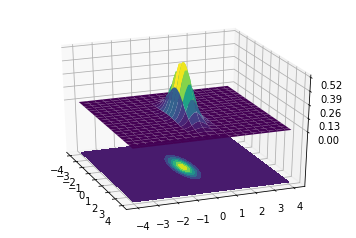

In [10]:
mu = [0, 0]
sigma = [[1.011, 0.004],[0.004, 0.089]]
xy_lim = 4
plot_3d_covariance(mu, sigma, xy_lim, xy_lim)

#### 3D-Plot: Teilkorrelierte Zufallsvariablen
Eine Korrelation äußert sich hier in der Drehung der Ellipse in der xy-Ebene, so dass diese *nicht* mehr parallel zu einer der beiden Achsen ausgerichtet ist.

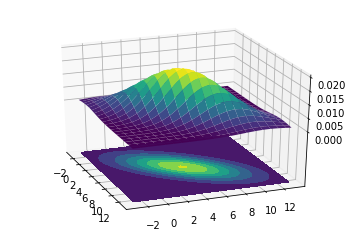

In [11]:
mu = [5, 5]
sigma = [[12.337, 8.604],[8.604, 12.617]]
xy_lim = 8
plot_3d_covariance(mu, sigma, xy_lim,xy_lim)

#### 3D-Plot: Studentische Körpergrößen-/Gewichtsverteilung
Auch hier ist die Korrelation zwischen Körpergröße und Gewicht durch die Drehung der Ellipse im Falschfarbenplot leicht sichtbar. Sie ist deutlich ausgeprägter als im vorherigen Beispiel, denn die Ellipse ist wesentlich schmaler.

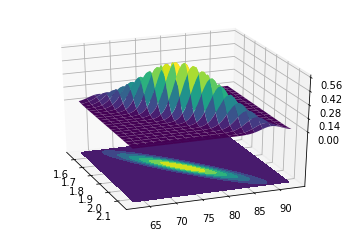

In [12]:
mu = [1.85, 77.8]
sigma = [[0.0209, 0.773],[0.773, 32.515]]
x_lim = 0.3
y_lim = 15
plot_3d_covariance(mu, sigma, x_lim, y_lim)

#### Komplett korrelierte Zufallsvariablen
Hier macht die 3D-Darstellung keinen Sinn. Entsprechend liefert die Darstellungsfunktion eine Fehlermeldung. Denn die 3D-Oberfläche wäre nur eine vertikale Scheibe und der Falschfarbenplot nur eine Linie.

### Konturplots von Konfidenzellipsen
Bei topografischen Karten sind Höhenlinien eingezeichnet, womit sich die Geländeform wesentlich einfacher erfassen lässt als alleine über die Falschfarbendarstellung. Hier spricht man von "Konturplots".  

Um die Kovarianzmatrix zweier Zufallsvariablen zu beurteilen, sind Konturplots wesentlich besser geeignet als 3D-Oberflächenplots. 
Die "Höhenlinien" sind hier konkret die Konturen mit konstanter Wahrscheinlichkeitsdichte $f(\mathbf{x},\boldsymbol{\mu},\Sigma)$ und bilden Ellipsen. Diese nennt man **Kovarianzellipsen** oder **Konfidenzellipsen**.  
Diese Ellipsen werden mit $1\sigma$, $2\sigma$ oder $3\sigma$ bezeichnet. 
Diese Standardabweichungen beziehen sich auf die beiden Halbachsen der Ellipsen. Befindet man sich beispielsweise an einem der vier Scheitelpunkte der Konfidenzellipse für $1 \sigma$, dann entspricht der Abstand zum Zentrum der Ellipse (also dem Punkt $(\mu_0,\mu_1)$) genau $\sigma_0$ bzw. $\sigma_1$, wie im nachfolgendem Plot dargestellt.
<img src="KonfEllipseEinSigma.png" width="600">  

Sind die Zufallsvariablen $x_0$ und $x_1$ korreliert, so dreht sich die Ellipse um ihr Zentrum $(\mu_0,\mu_1)$. Die beiden Halbachsen vergrößern sich dann, denn ihre *Projektion* auf die Achsen $x_0$ bzw. $x_1$ entsprechen nach wie vor den Standardabweichungen $\sigma_0$ bzw. $\sigma_1$.

Für den Kippwinkel der Ellipse gilt:
$$ \tan 2 \alpha = {{2 \sigma_{01} \sigma_0 \sigma_1} \over {\sigma_0^2 - \sigma_1^2}}$$

Bleibt noch die Frage, wie groß ist das Vertrauensniveau für die $1\sigma$, $2\sigma$ oder $3\sigma$ Konfidenzellipse? Oder anders ausgedrückt: Wie viel Prozent der Zufallswerte liegen innerhalb der jeweiligen Ellipse?  
Die Antwort darauf gibt die Verteilungfunktion der sogenannten Chi-Quadrat-Verteilung (Details siehe [How to draw a covariance error ellipse?](visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix)). Dies kann man mit der SciPy-Funktion ``stats.chi2.cdf(m,2)`` ausrechnen, wobei $m$ die Anzahl der Standardabweichungen ist:

In [13]:
from scipy import stats
for m in range(3):
    print('{0} Standardabweichung(en): Vertrauensniveau = {1} %'.format(m+1, stats.chi2.cdf((m+1)**2, 2)*100))

1 Standardabweichung(en): Vertrauensniveau = 39.346934028736655 %
2 Standardabweichung(en): Vertrauensniveau = 86.46647167633873 %
3 Standardabweichung(en): Vertrauensniveau = 98.88910034617578 %


Innerhalb der Konfidenzellipse für $3\sigma$ befinden sich also 98,89 % aller Werte der Zufallsverteilung.  
Ab hier werden nur noch Konturplots verwendet. Die folgende Funktion ``plot_cont_covariance`` übernimmt die Erstellung des Konturplots, indem sie aus der Kovarianzmatrix ``sigma`` die Ellipsen für die in der Liste ``std`` vorgegebenen Anzahl von Standardabweichungen berechnet und darstellt.

In [14]:
import math
import scipy.linalg as linalg
from matplotlib.patches import Ellipse

# Computes orientation, width and heigt of the ellipse of covariance matrix
def covariance_ellipse(sigma):
    U, s, _ = linalg.svd(sigma)
    orientation = math.atan2(U[1, 0], U[0, 0])
    width = math.sqrt(s[0])
    height = math.sqrt(s[1])
    if height > width: raise ValueError('width must be greater than height')       
    return (orientation, width, height)

#plots the ellipse of covariance matrix
def plot_covariance(mu, sigma=None, std=None, axis_equal=True, show_center=True,
                    facecolor='none', edgecolor='k',alpha=1.0, x_lim=None, y_lim=None, ls='solid'):
    ellipse = covariance_ellipse(sigma)
    angle = np.degrees(ellipse[0])
    width = ellipse[1] * 2.
    height = ellipse[2] * 2.

    #fig, ax = plt.subplots()
    ax = plt.gca() # get handle of current plot
    ax.grid()
    for sd in std:
        e = Ellipse(xy=mu, width=sd*width, height=sd*height, angle=angle,
                    facecolor=facecolor, edgecolor=edgecolor, alpha=alpha, lw=2, ls=ls)
        ax.add_patch(e)
    x, y = mu
    
    if axis_equal: plt.axis('equal')
    if show_center: plt.scatter(x, y, marker='+',alpha=alpha, color=edgecolor)
    if x_lim is not None: ax.set_xlim(x-x_lim,x+x_lim)
    if y_lim is not None: ax.set_ylim(y-y_lim,y+y_lim)

#### Konfidenzellipsen: Studentische Körpergrößen-/Gewichtsverteilung
Im nachfolgenden Plot wird als Beispiel die studentische Körpergrößen-/Gewichtsverteilung als Konfidenzellipse für $1\sigma$, $2\sigma$ und $3\sigma$ aus der Kovarianzmatrix $\mathbf\Sigma$ und dem Erwartungswert $\boldsymbol\mu$
$$
\mathbf\Sigma = \begin{bmatrix}
  0,0209 & 0,773 \\
  0,773 & 32,515  \\
 \end{bmatrix}
\qquad
\boldsymbol\mu = \begin{bmatrix}1,85\\77,8\end{bmatrix} 
$$
berechnet und darstellt.

Text(0,0.5,'Gewicht (kg)')

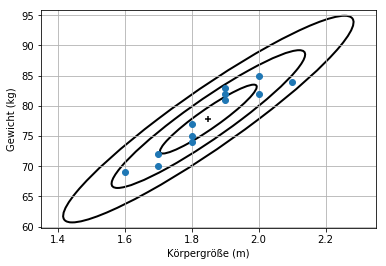

In [15]:
sigma = [[0.0209, 0.773], [0.773, 32.515]]
mu =[1.85, 77.8]
fig, ax = plt.subplots()
plot_covariance(mu, sigma, alpha=1, std=[1, 2, 3], axis_equal=False, x_lim=0.5, y_lim=18)
#ax = plt.gca() # get handle of current plot to add the data points to the ellipse plot
ax.plot(X_0, X_1, 'o')
ax.set_xlabel('Körpergröße (m)')
ax.set_ylabel('Gewicht (kg)')

In dem obigen Plot ist durch die Schräglage (positive Steigung) der Ellipsen die (positive) Korrelation zwischen Körpergröße und Gewicht zu erkennen. Die äußere Ellipse gibt das $3\sigma$-Vertrauensintevall wieder, in dem sich 98,9 % aller Zufallsvariablen-Wertepaare befinden. Die Wertepaare sind durch die blauen Punkte dargestellt. Bis auf den größten Studierenden liegen alle sogar innerhalb des $2\sigma$-Vertrauensintervalls.  
Je schmaler diese geneigte Ellipse ist, desto stärker sind die beiden Werte Körpergröße und Gewicht korreliert. Denn für eine gegebene Körpergröße kommt dann nur noch ein kleiner Bereich von möglichen Gewichtswerten in Frage. Hat sie eine positive Steigung, dann sind die Werte positiv korreliert. Bei einer negativen Steigung sind die Werte negativ korreliert - in diesem Fall wären die Studierenden dann umso leichter je größer sie sind. 
Die Projektion der $1 \sigma$-Ellipse auf die x-Achse entspricht der Standardabweichung der Körpergrößen, und die Projektion auf die y-Achse der Standardabweichung der Gewichte. 

#### Konfidenzellipsen:  Komplett unkorrelierte Zufallsvariablen
Im Vergleich zum Plot zuvor sind hier die Konfidenzellipsen parallel zur x- bzw. y-Achse ausgerichtet. Die innere 1$\sigma$-Ellipse besitzt eine große Halbachse der Länge 1,011 und eine kleine Halbachse der Länge 0,089 - die beiden Diagonalelemente der Kovarianzmatrix $\mathbf\Sigma$.

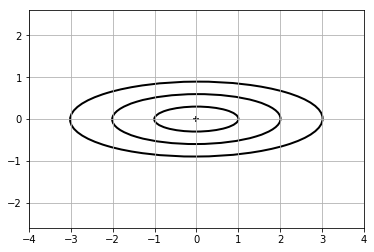

In [16]:
sigma = [[1.011, 0.004],[0.004, 0.089]]
mu = [0, 0]
fig, ax = plt.subplots()
plot_covariance(mu, sigma, alpha=1, std=[1, 2, 3], axis_equal=True, x_lim=4, y_lim=8)

## Multiplikation mehrdimensionaler Gaußverteilungen
Beim mehrdimensionalen Kalman-Filter besteht wie im eindimensionalen Fall der Korrekturschritt aus der Multiplikation zweier Gaußverteilungen. Der nachfolgende Plot verdeutlicht nochmals den eindimensionalen Fall aus dem Jupyter-Notebook zum eindimensionalen Kalmanfilter, Teil 1:
<img src="EindimGaussMultiplikation.png" width="600">
Der Korrekturschritt besteht aus der Multiplikation der Gaußverteilung aus der Vorhersage und aus der Messung. Die Breite der daraus resultierenden Gaußverteilung ist kleiner als jede der beiden anderen. Mit anderen Worten, der Schätzwert der Zustandsgröße hat eine geringere Unsicherheit als vorher - das Roboterfahrzeug wird besser lokalisiert.  

Im mehrdimensionalen Fall ändert sich der Algorithmus des Kalman-Filters nicht: Der Korrekturschritt ist immer noch die Multiplikation zweier Gaußverteilungen - nun aber die Multiplikation mehrdimensionaler Gaußverteilungen. Nur die Parameter ändern sich von Skalaren auf Vektoren oder Matrizen, und die Mathematik wird etwas komplexer.  

Nachfolgend sind die Rechenregeln für den mehrdimensionalen Fall dargestellt: Aus dem Erwartungswerten der Vorhersage $\bar{\boldsymbol\mu}$ und der Messung $\boldsymbol\mu_z$ wird der Erwartungswert $\boldsymbol\mu$ der Korrektur berechnet. Aus den entsprechenden Kovarianzmatrizen $\bar{\mathbf\Sigma}$ und $\mathbf\Sigma_z$ wird die Kovarianzmatrix $\mathbf\Sigma$ der Korrektur berechnet.

Nachfolgend sind die allgemeinen Gleichungen wiedergegeben, nach denen zwei zweidimensionale Gaußverteilungen mit $\boldsymbol\mu_1$, $\mathbf\Sigma_1$ bzw. $\boldsymbol\mu_2$, $\mathbf\Sigma_2$ multipliziert werden. 
Hierbei ist $\boldsymbol\mu$ ein zweidimensionaler Vektor und $\mathbf\Sigma$ eine 2x2-Matrix.

$$\begin{aligned}
\mu &= \mathbf\Sigma_2(\mathbf\Sigma_1 + \mathbf\Sigma_2)^{-1}\mu_1 + \mathbf\Sigma_1(\mathbf\Sigma_1 + \mathbf\Sigma_2)^{-1}\mu_2 \\
\mathbf\Sigma &= \mathbf\Sigma_1(\mathbf\Sigma_1+\mathbf\Sigma_2)^{-1}\mathbf\Sigma_2
\end{aligned}$$

Im nächsten Jupyter-Notebook wird genau diese Rechenvorschrift für die Funktion ``update()`` verwendet. Die Vector- und Matrixmultiplikation erledigt die Bibliothek ``NumPy``.

Vergleicht man obige Formeln mit den entsprechenden für den eindimensionalen Fall,

$$\begin{aligned}
\mu &=\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}
\end{aligned}$$

so wird sichtbar, dass der Vektor $\boldsymbol\mu$ dem Skalar $\mu$ und die Matrix $\mathbf\Sigma$ dem Skalar $\sigma$ entsprechen.

Die inverse Matrix $\mathbf{A}^{-1}$ der Matrix $\mathbf A$ ist definiert über $\mathbf{AA}^{-1} =I$. Generell kann man nicht "durch eine Matrix teilen". Aber die Multiplikation mit der inversen Matrix ist salopp gesagt so etwas Ähnliches. Daher kann man die Formeln für den zweidimensionalen Fall salopp (und unter Verachtung durch echte Mathematiker) auch so schreiben:

$$\begin{aligned}
\boldsymbol\mu &\approx \frac{\mathbf\Sigma_2\boldsymbol\mu_1 + \mathbf\Sigma_1\boldsymbol\mu_2}{\mathbf\Sigma_1 + \mathbf\Sigma_2} \\ \\
\mathbf\Sigma &\approx \frac{\mathbf\Sigma_1\mathbf\Sigma_2}{(\mathbf\Sigma_1+\mathbf\Sigma_2)}
\end{aligned}$$

In dieser Form wird klar, dass der Übergang von eine auf zwei Dimensionen und allgemein auf n Dimensionen eigentlich auch an der Mathematik nichts Weltbewegendes ändert.

## Nutzung der Kovarianz zur Verbesserung einer Vorhersage:Anschauliche Erklärung
Ausgangspunkt dieses Jupyter-Notebooks war der fehlende Skalierungsfaktor $h$ beim eindimensionalen Kalman-Filter. Oder anders ausgedrückt das Unvermögen des eindimensionalen Kalman-Filters, in dessem physikalischen Modell die Änderungsrate der Zustandsgröße dem bisherigen Messwertverlauf anzupassen.  
*Was hat das mit der Kovarianz zu tun?*  

Die Erklärung hierzu ist nicht ganz einfach und wird im Folgenden am konkreten Beispiel des bekannten Roboterfahrzeugs beschrieben, welches geradlinig schräg zu einer Wand fahren soll, wie im Bild unten nochmals verdeutlicht.
<img src="RoboFahrzeug15Grad.png" width="600">

Beim eindimensionalen Kalman-Filter war der Abstand $z$ die (einzige) Messgröße. Die zeitliche Änderung von $z$, also die Geschwindigkeit $v = {d \over dt} z$, wurde weder gemessen noch im Filteralgorithms berechnet bzw. verwendet. Genau dies war ja der Grund, weshalb der Filter mit einem realitätsfernen $v$ im physikalischen Modell den wahren Abstandsdaten "hinterher lief".  

Für das Beispiel oben gibt es beim eindimensionalen Kalmanfilter die Zustandsgröße "Abstand" $x = z$, die einen Erwartungswert $\mu$ und eine Standardabweichung $\sigma$ besitzt. Im nachfolgenden Plot ist dies zu drei Zeitpunkten verdeutlicht. Die Fehlerbalken symbolisieren die Standardabweichung und die Datenpunkte symbolisieren die Erwartungswerte von $z$.

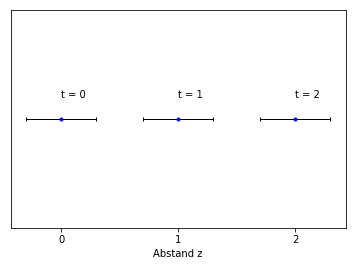

In [17]:
t = np.linspace(0, 2, 3)

z = np.linspace(0, 0, 3)

fig, ax = plt.subplots()

ax.errorbar(t, z, xerr=0.3, fmt='.', color='b', ecolor='k', elinewidth=1, capsize=2);
#ax.grid(linestyle=':')
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticks(t)
ax.set_ylim(-0.5,0.5)
for z_val in t:
    ax.text(z_val, 0.1, 't = {:1.0f}'.format(z_val),size=10, color='k')
ax.set(xlabel='Abstand z');

Angenommen, das Roboterfahrzeug habe nun zwei Sensoren: Ein Sensor misst nach wie vor den Abstand $z$ zur Wand. Ein zweiter Sensor misst zusätzlich die Relativgeschwindikgeit $v$ zur Wand. Somit gibt es nun zwei Zustandsgrößen: $x_0 = z$ sowie $x_1 = v$.
Wieder soll das Roboterfahrzeug sich geradlinig von der Wand weg bewegen. D.h. seine Relativgeschwindigkeit zur Wand ist nahezu konstant. Jedoch ist die Messung dieser Geschwindigkeit mit einer recht hohen Messunsicherheit behaftet - vielleicht daher, weil ein einfacher Doppler-Radarsensor dazu verwendet wird.  
Der Plot oben erhält nun noch eine y-Achse auf der die Geschwindigkeit aufgetragen ist. Die Messunsicherheit, also beispielsweise 3$\sigma$ der Geschwindigkeitsmessung ist ebenso wie 3$\sigma$ des Abstands durch Fehlerbalken symbolisiert.

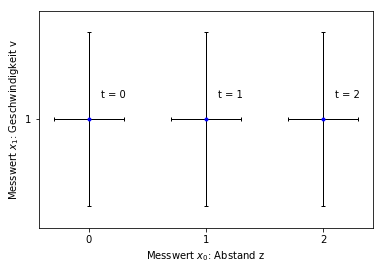

In [18]:
t = np.linspace(0, 2, 3)

z = np.linspace(1, 1, 3)

fig, ax = plt.subplots()
ax.errorbar(t, z, xerr=0.3, yerr=0.4, fmt='.', color='b', ecolor='k', elinewidth=1, capsize=2);
#ax.grid(linestyle=':')
#ax.set_yticklabels([])
ax.set_yticks([1])
ax.set_xticks(t)
ax.set_ylim(-0.5,2.5)
ax.set_ylim(0.5,1.5)
for z_val in t:
    ax.text(z_val+ 0.1, 1.1, 't = {:1.0f}'.format(z_val),size=10, color='k')
ax.set(xlabel='Messwert $x_0$: Abstand z');
ax.set(ylabel='Messwert $x_1$: Geschwindigkeit v');

Schaut man sich den Verlauf der Messwerte im Plot oben genauer an, dann sollte man spätestens zum Zeipunkt $t=2$ den Kopf schütteln:  
Im physikalischen Modell nehmen wir an, das Fahrzeug bewege sich nur geradlinig. Deshalb können wir dessen Geschwindigkeit $v$ zur Zeit $t=2$ aufgrund der voran gegangenen Abstandsmesswerte wesentlich genauer vorhersagen, als unserer billiger Radarsensor es messen kann. Da sich zwischen $t = 0$ und $t=1$ der Abstand um 1 geändert hat, wird man für den Zeitpunkt $t=2$ die Geschwindigkeit weitaus genauer vorhersagen können, als der Fehlerbalken im Plot angibt. Diese Vorhersage zusammen mit dem (schlecheten) Messwert ergibt dann einen Schätzwert, welcher nicht nur die Geschwindigkeit sondern auch die Position genauer bestimmt als der Messwert alleine.  

Den statistischen Unsicherheiten im Plot oben kann man statt über Fehlerbalken auch mit Konvidenzellipsen darstellen: Aus dem Fehlerbalkenkreuz wird eine Ellipse mit den entsprechenden Halbachsen. Damit ergibt sich der nachfolgende Plot, welcher genau die gleiche Aussagekraft hat wie der mit den Fehlerbalken.

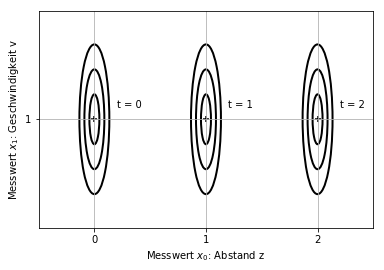

In [19]:
t = np.linspace(0, 2, 3)

z = np.linspace(1, 1, 3)

fig, ax = plt.subplots()
sigma = [[0.002, 0.000],[0.000, 0.05]]
for z_val in t:
    mu = [z_val, 1]
    plot_covariance(mu, sigma, alpha=1, std=[1,2,3], axis_equal=True)
    ax.text(z_val+ 0.2, 1.1, 't = {:1.0f}'.format(z_val),size=10, color='k')
ax.set_yticks([1])
ax.set_xticks(t)
ax.set_xlim(-0.5,2.5)
ax.set_ylim(0.5,1.5)
ax.set(xlabel='Messwert $x_0$: Abstand z');
ax.set(ylabel='Messwert $x_1$: Geschwindigkeit v');

Die drei Konfidenzellipsen sind alle zur x- bzw. y-Achse ausgerichtet. Dies bedeutet, dass die Messwerte oder besser gesagt die Messwertstreuung für den Abstand und für die Geschwindigkeit unkorreliert sind. Das ist auch nicht verwunderlich, denn es sind ja zwei völlig von einander unabhängige Sensoren, die diese Messdaten liefern.  
Die Vorhersage für den Zeitpunkt $t=2$ lässt sich ebenfalls als Konfidenzellipse darstellen. In *dieser* Ellipse steckt nun die Korrelation zwischen dem Abstand und der Geschwindigkeit, welcher intuitv völlig klar ist: Ist der Abstand zum Zeitpunkt $t=2$ größer als 2, dann muss die Geschwindigkeit größer 1 gewesen sein. Ist der Abstand kleiner 2, dann war die Geschwindigkeit kleiner 1.  
> Abstand und Geschwindigkeit sind also positiv korreliert.  

Zwischen $t = 0$ und $t=1$ hatte der Abstand sich um 1 geändert: Somit ist zur Zeit $t=2$ der wahrscheinlichste Wert für den nächsten Abstand $\mu_0$ 2 und für die nächste Geschwindigkeit $\mu_1$  1.    
**Die Vorhersage ist also eine Konfidenzellipse, welche ihr Zentrum im Punkt $(\mu_0=2,\mu_1=1)$ besitzt und durch ihre große Halbachse in Richtung nach Rechts Oben die Korrelation zwischen Abstand und Geschwindigkeit anzeigt.** Diese Konfidenzellipse der Vorhersage ist im folgenden Plot rot dargestellt.

Text(0.3,0.1,'Korrekturwert')

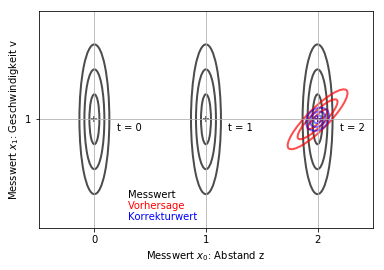

In [20]:
t = np.linspace(0, 2, 3)

z = np.linspace(1, 1, 3)

fig, ax = plt.subplots()
sigma = [[0.002, 0.000],[0.000, 0.05]]
for z_val in t:
    mu = [z_val, 1]
    plot_covariance(mu, sigma, alpha=0.7, std=[1,2,3], axis_equal=True)
    ax.text(z_val+ 0.2, 0.9, 't = {:1.0f}'.format(z_val),size=10, color='k')
sigma_predict = [[0.008, 0.007],[0.007, 0.008]]
sigma_update = [[0.0012, 0.0003],[0.0003, 0.0012]]
plot_covariance([2,1], sigma_predict, alpha=0.7, std=[1,2,3], axis_equal=True, edgecolor='r')
plot_covariance([2,1], sigma_update, alpha=0.5, std=[1,2,3], axis_equal=True, edgecolor='b')
ax.set_yticks([1])
ax.set_xticks(t)
ax.set_xlim(-0.5,2.5)
ax.set_ylim(0.5,1.5)
ax.set(xlabel='Messwert $x_0$: Abstand z');
ax.set(ylabel='Messwert $x_1$: Geschwindigkeit v');
ax.text(0.3, 0.3, 'Messwert'.format(z_val),size=10, color='k')
ax.text(0.3, 0.2, 'Vorhersage'.format(z_val),size=10, color='r')
ax.text(0.3, 0.1, 'Korrekturwert'.format(z_val),size=10, color='b')

Im Plot oben ist zum Zeitpunkt $t=2$ die Messung durch die schwarze Ellipse und die Vorhersage durch die rote Ellipse visualisiert. Die rote Ellipse ist die Kovarianzmatrix zwischen dem Abstand und der Geschwindigkeit. Ihre Schrägstellung zeigt eine starke Korrelation zwischen diesen beiden Zustandsgrößen an. Diese Korrelation kommt aus dem physikalischen Modell, wie im nächsten Jupyter-Notebook dargestellt wird.  
Wäre die Korrelation nicht im pyhsikalischen Modell vorhanden, dann wäre die rote Ellipse genau so wie die schwarze mit ihrer Halbachse parallel zur y-Achse ausgerichtet.  

**Jetzt kommt der Clou:** 
>*Der Korrekturschritt ist wie im eindimensionalen Fall eine Multiplikation der beiden Gaußverteilungen der Vorhersage (rot) und der Messung (schwarz). Das Produkt (blau), also **die neuen Schätzwerte von Position und Geschwindigkeit streuen weitaus weniger als jeweils die Vorhersage bzw. die Messung allein.  
Für diese starke Abnahme der Unsicherheit ist die Schrägstellung der roten Ellipse, also die Korrelation verantwortlich.** 
Mehr noch: Selbst **wenn die Geschwindigkeit gar nicht gemessen wird** - die schwarze Ellipse also eine sehr große vertikale Ausdehnung besitzt, **ergibt die blaue Konfidenzellipse trotzdem einen sehr guten Schätzwert für die Geschwindigkeit**.*  

>Der hier lediglich grob visualisierte zweidimensionale Kalman-Filter für Abstand und Geschwindigkeit hat also zwei Vorteile:
>* Im physikalischen Modell wird nun die **Geschwindigkeit dem voran gegangenen Messwertverlauf angepasst** ähnlich wie beim g-h-Filter. (Der geschätzte Wert der Geschwindigkeit steckt im Erwartungswert der zweidimensionalen Wahrscheinlichkeitsverteilung.)
>* Der Filter **liefert nun auch die Geschwindigkeit als Schätzwert**, selbst wenn diese gar nicht gemessen wird. (Dieser Schätzwert wird mit Hilfe der Kovarianzmatrix der Vorhersage präzisiert. Die Kovarianzmatrix selbst ergibt sich aus dem physikalischen Modell.)

Wie genau die iterative Berechnung des Erwartungswertvektors und der Kovarianzmatrix funktioniert wird im nächsten Jupyter-Notebook gezeigt.  